# Pose-HG-3D Implementation
Github: https://github.com/xingyizhou/pytorch-pose-hg-3d
Paper: https://arxiv.org/pdf/1704.02447.pdf

For now, mount drive and drag in debugger.py, eval.py, image.py, msra_resnet.py

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from msra_resnet import get_pose_net
from image import get_affine_transform, transform_preds
from eval import get_preds, get_preds_3d
from debugger import Debugger, show_2d

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Key variables for model declaration
num_output = 16
num_output_depth = num_output #might be 0 instead, probs just 16
heads = {'hm': num_output}
print(heads)
if num_output_depth > 0:
  heads['depth'] = num_output_depth
print('heads', heads)
num_layers = 50

{'hm': 16}
heads {'hm': 16, 'depth': 16}


In [4]:
#Initialise Model
model = get_pose_net(num_layers, heads)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



=> loading pretrained model https://download.pytorch.org/models/resnet50-19c8e357.pth


In [5]:
checkpoint = torch.load('drive/MyDrive/GKBodyPose/statedict/fusion_3d_var.pth', map_location=lambda storage, loc: storage)

In [6]:
print(checkpoint['epoch'])

10


In [7]:
#Load pre-trained model
model.load_state_dict(checkpoint['state_dict'], strict=False)

<All keys matched successfully>

In [8]:
#Use CUDA GPU and convert model to evaluation mode
model.to('cuda:0')
model.eval()

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [67]:
#Import image
image = cv2.imread('lloris2.png')

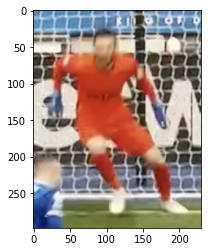

In [76]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [69]:
image.shape

(298, 230, 3)

In [70]:
#Key variables for image
input_h, input_w = 256, 256
#input_h, input_w = image.shape[0], image.shape[1]
output_h, output_w = 64, 64
mean = np.array([0.485, 0.456, 0.406], np.float32).reshape(1, 1, 3)
std = np.array([0.229, 0.224, 0.225], np.float32).reshape(1, 1, 3)

In [71]:
#Process Image
s = max(image.shape[0], image.shape[1]) * 1.0
c = np.array([image.shape[1] / 2., image.shape[0] / 2.], dtype=np.float32)
trans_input = get_affine_transform(c, s, 0, [input_w, input_h])
inp = cv2.warpAffine(image, trans_input, (input_w, input_h), flags=cv2.INTER_LINEAR)
inp = (inp / 255. - mean) / std
inp = inp.transpose(2, 0, 1)[np.newaxis, ...].astype(np.float32)
inp = torch.from_numpy(inp).to('cuda:0')

In [72]:
#Get model prediction
out = model(inp)[-1]

In [73]:
#Process Predictions
pred = get_preds(out['hm'].detach().cpu().numpy())[0]
pred = transform_preds(pred, c, s, (output_w, output_h))
pred_3d = get_preds_3d(out['hm'].detach().cpu().numpy(), out['depth'].detach().cpu().numpy())[0]

In [74]:
#3D Pose Prediction
pred_3d

array([[ 0.046875  ,  0.34375   , -0.07917646],
       [-0.03125   ,  0.15625   , -0.19643399],
       [-0.078125  ,  0.015625  , -0.01154552],
       [ 0.0625    ,  0.        ,  0.00202423],
       [ 0.234375  ,  0.203125  , -0.00870731],
       [ 0.28125   ,  0.390625  , -0.01727348],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.234375  , -0.03932626],
       [ 0.        , -0.21875   , -0.1113706 ],
       [ 0.        , -0.375     , -0.068075  ],
       [-0.25      , -0.078125  , -0.010424  ],
       [-0.21875   , -0.21875   , -0.00597422],
       [-0.125     , -0.234375  , -0.04821233],
       [ 0.109375  , -0.234375  , -0.06696545],
       [ 0.1875    , -0.140625  ,  0.00216316],
       [ 0.25      , -0.03125   , -0.01095216]], dtype=float32)

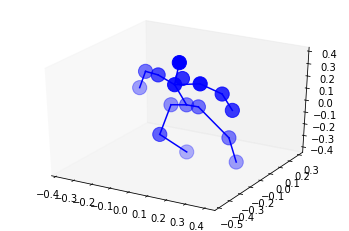

In [75]:
#Plot 3D pose
debugger = Debugger()
debugger.add_img(image)
debugger.add_point_2d(pred, (255, 0, 0))
debugger.add_point_3d(pred_3d, 'b')
#debugger.show_all_imgs(pause=False)
debugger.show_3d()

In [75]:
mpii_edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], 
              [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15], 
              [6, 8], [8, 9]]